## Tabnet

In [11]:
def upgrade_runtime_ram():
    meminfo = subprocess.getoutput('cat /proc/meminfo').split('\n')

    memory_info = {entry.split(':')[0]: int(entry.split(':')[1].replace(' kB','').strip()) for entry in meminfo}

    if memory_info['MemTotal'] > 17000000:
        return

    a = []
    while(1):
        a.append('1')

In [13]:
def restart_runtime():
    os.kill(os.getpid(), 9)

In [15]:
def setup_rapids():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    device_name = pynvml.nvmlDeviceGetName(handle)
    if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
        print("Wrong GPU - Restarting Runtime")
        restart_runtime()


    # clone RAPIDS AI rapidsai-csp-utils scripts repo
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git

    # install RAPIDS
    !bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13


    # set necessary environment variables 
    dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
    sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
    sys.path

    # update pyarrow & modules 
    exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [17]:
def setup_conda():
    if not 'Miniconda3-4.5.4-Linux-x86_64.sh' in os.listdir():
        !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

    if not ('EPFL-Capstone-Project' in os.listdir()) and (os.getcwd().split('/')[-1] != 'EPFL-Capstone-Project'):
        !git clone https://github.com/helmigsimon/EPFL-Capstone-Project  
    if 'EPFL-Capstone-Project' in os.listdir():
        os.chdir('EPFL-Capstone-Project')

    !conda env create -f environment.yml
    !conda activate exts-ml

In [19]:
def setup_drive():
    #Mounting Google Drive
    global drive
    from google.colab import drive
    drive.mount('/content/drive')

In [21]:
try:
    import sys,os,subprocess
    
    upgrade_runtime_ram()
    setup_drive()

    #Setting up PyPi Packages
    !pip install sparse-dot-topn pdpipe category-encoders tabnet[gpu]
    import sparse_dot_topn.sparse_dot_topn as ct
    import pdpipe as pdp
    import category_encoders
    import tabnet

    #Setting up Conda Packages
    setup_conda()
    !conda install -y tensorflow==2.1

    
    #Initializing NLTK
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    
except ModuleNotFoundError as e:
    print(e)
    print('Not in colab environment, continuing to run locally')
    from umap import UMAP

ValueError: invalid literal for int() with base 10: '/proc/meminfo'

In [22]:
import tensorflow as tf
import tabnet
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [23]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [24]:
from lib.processing import load_from_pkl
from data.util.paths import DATA_PATH
from lib.pipelines import *

In [25]:
api_df, extracted_df = load_from_pkl('api',DATA_PATH), load_from_pkl('extracted',DATA_PATH)

In [26]:
api_df = api_pipe.fit_transform(api_df)

In [27]:
extracted_df = extracted_pipe.fit_transform(extracted_df)

In [28]:
with np.load(os.path.join(DATA_PATH,'high_level_features_labelled.npz')) as data:
    image_embedding_df = pd.concat([pd.DataFrame(data[section]) for section in ('release_id','bitmap','features')],axis=1)
    image_embedding_df.columns = ['release_id', 'bitmap'] + ['feature_%s' % i for i in range(1,1281)]

In [29]:
scaler = StandardScaler()
pca = PCA(n_components=10)
image_embeddings_scaled = scaler.fit_transform(image_embedding_df.loc[:,['feature_%s' % i for i in range(1,1281)]])

In [30]:
image_embeddings_reduced = pca.fit_transform(image_embeddings_scaled)

In [31]:
image_embeddings_reduced = pd.concat([
      image_embedding_df.loc[:,'release_id'],
      pd.DataFrame(
          image_embeddings_reduced,
          columns = ['images_umap_%s' % i for i in range(image_embeddings_reduced.shape[1])]
      )],
      axis=1
)


Combining datasets

In [32]:
df = api_df.merge(extracted_df,how='inner',on='release_id')
df = df.merge(image_embeddings_reduced,how='inner',on='release_id')

In [33]:
df_sample = df.sample(frac=0.1)

In [34]:
del api_df, extracted_df, image_embedding_df, image_embeddings_scaled, image_embeddings_reduced

In [35]:
record_store_tabnet_transformer = ColumnTransformer(transformers=[
    ('year_encoder', OneHotEncoder(dtype=np.uint8,handle_unknown='ignore'), ['year']),
    ('format_name', OneHotEncoder(dtype=np.uint8,handle_unknown='ignore'), ['format_name'])
], remainder='passthrough')

In [36]:
record_store_tabnet_removal_columns = [
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title',
]

In [37]:
record_store_tabnet_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','master_id'])),
    ('record_store_column_remover', ColumnRemover(record_store_tabnet_removal_columns)),
    ('preprocessing',record_store_tabnet_transformer),
    ('scaler', StandardScaler()),
])

In [200]:
df_arr = record_store_tabnet_pipe.fit_transform(df.drop('market_value',axis=1),np.log(df.market_value))

In [202]:
df_pretensor = np.concatenate([df_arr,np.log(df['market_value']).values.reshape(-1,1)],axis=1)
np.random.shuffle(df_pretensor)

In [203]:
ds = tf.data.Dataset.from_tensor_slices(df_pretensor)

In [204]:
def transform(ds):
    unstacked = tf.unstack(ds)
    features = unstacked[:-1]
    
    x = dict(zip(col_names,features))
    y = unstacked[-1]
    
    return x,y

In [205]:
col_names = ['column_%s' % i for i in range(df_arr.shape[1])]

In [206]:
train_size = int(0.6*len(df_arr))
BATCH_SIZE = 5000
ds_train = ds.take(train_size)
ds_train = ds_train.map(transform)
ds_train = ds_train.batch(BATCH_SIZE)

In [207]:
val_size = int(0.2*len(df_arr))
ds_val = ds.skip(train_size).take(val_size)
ds_val = ds_val.map(transform)
ds_val = ds_val.batch(BATCH_SIZE)

In [208]:
ds_test = ds.skip(train_size).skip(val_size)
ds_test = ds_test.map(transform)
ds_test = ds_test.batch(BATCH_SIZE)

In [209]:
feature_columns = [tf.feature_column.numeric_column(column) for column in col_names]

## Tabnet Paper Hyperparam Ranges
- Nd/Na (Feature_dim,Output_dim) -> {8,16,24,32,64,128}
- Nsteps (Number of decision steps) -> np.arange(3,11,1)
- gamma (relaxation factor) -> {1,1.2,1.5,2.0}
- lambda_sparse (sparsity coefficient) -> {0, 1e-6, 1e-4, 1e-3, 1e-2, 1e-1}
- Batch Size -> {256,512,1024,2048,4096,8192,16384,32768}


In [210]:
model = tabnet.TabNetRegressor(
    feature_columns,
    feature_dim=128,
    output_dim=128,
    num_regressors=len(feature_columns),
    num_decision_steps=6,
    relaxation_factor=1,
    sparsity_coefficient=1e-1,    
)

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01,decay_steps=50,decay_rate=0.9,staircase=False)
optimizer = tf.keras.optimizers.Adam(lr)

model.compile(optimizer,loss='mean_squared_error',metrics=['mean_absolute_error'])

In [212]:
history = model.fit(ds_train,epochs=1000,validation_data=ds_val,verbose=100,callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Train for 36 steps, validate for 12 steps
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000


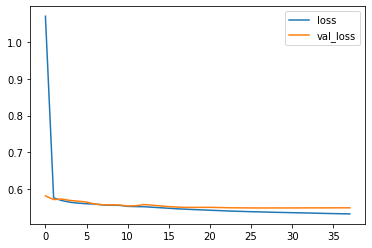

In [213]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

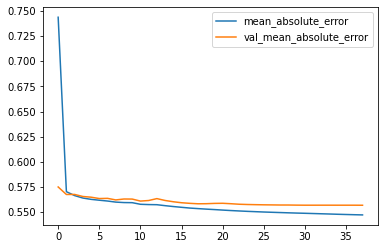

In [214]:
plt.plot(history.history['mean_absolute_error'],label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'],label='val_mean_absolute_error')
plt.legend()
plt.show()

In [182]:
predictions = model.tabnet.predict(ds_test)

In [185]:
predictions = model.predict(ds_t)